### User 1


================ Run 1 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 1 - Accuracy: 0.7317, Macro F1: 0.7105, F1 Class 0: 0.4756, F1 Class 1: 0.6953, F1 Class 2: 0.9605

================ Run 2 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 2 - Accuracy: 0.7613, Macro F1: 0.7425, F1 Class 0: 0.6316, F1 Class 1: 0.7285, F1 Class 2: 0.8673

================ Run 3 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Run 3 - Accuracy: 0.7322, Macro F1: 0.7091, F1 Class 0: 0.4743, F1 Class 1: 0.6996, F1 Class 2: 0.9533

================ Run 4 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 4 - Accuracy: 0.7327, Macro F1: 0.7084, F1 Class 0: 0.4765, F1 Class 1: 0.7034, F1 Class 2: 0.9454

================ Run 5 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Run 5 - Accuracy: 0.7465, Macro F1: 0.7147, F1 Class 0: 0.5318, F1 Class 1: 0.7257, F1 Class 2: 0.8865


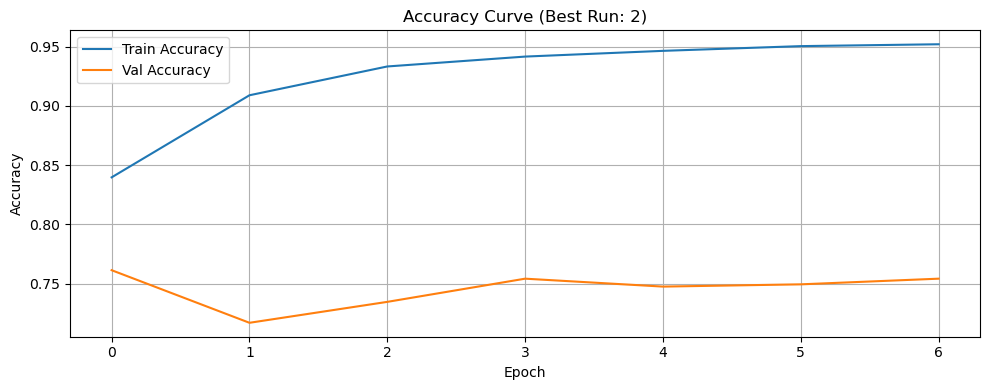

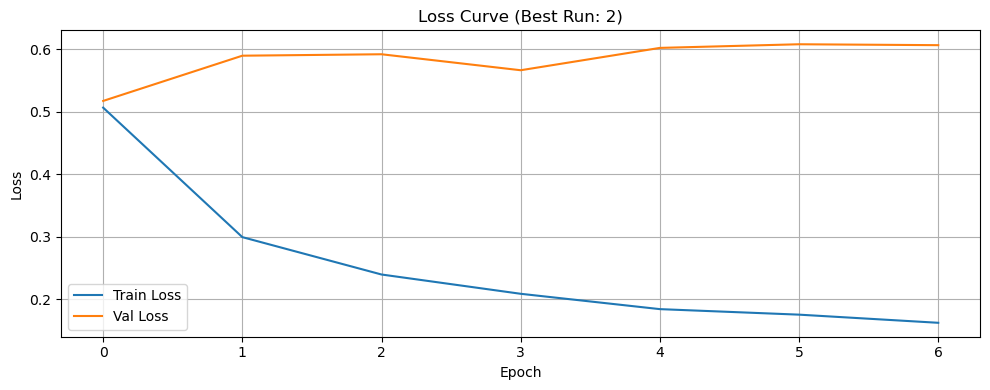


== Confusion Matrix of Best Run (Run 2) ==



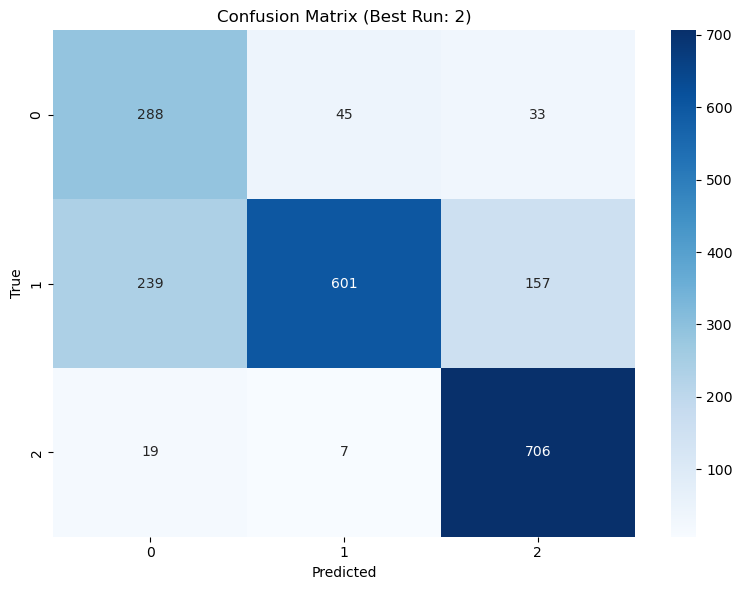

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.731742  0.710479    0.475645    0.695294    0.960499
1     0.761337  0.742462    0.631579    0.728485    0.867322
2     0.732220  0.709077    0.474347    0.699588    0.953297
3     0.732697  0.708409    0.476471    0.703400    0.945355
4     0.746539  0.714659    0.531765    0.725734    0.886480
Mean  0.740907  0.717017    0.517961    0.710500    0.922590
Std   0.011627  0.012907    0.060851    0.013829    0.038097

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.965542,0.728878,0.123093,0.785005
1,0.952001,0.754177,0.162397,0.606292
2,0.962520,0.715513,0.131078,0.729856
3,0.968928,0.722196,0.112984,0.801175
4,0.970983,0.740334,0.104622,0.776576
Mean,0.963995,0.732220,0.126835,0.739781
Std,0.006657,0.013702,0.019909,0.070832


In [27]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8']
test_users = ['user1']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [28]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.419786  0.683607  0.517961   366.000000  0.073876  0.062526   
1             0.856432  0.607823  0.710500   997.000000  0.036338  0.021135   
2             0.899578  0.950820  0.922590   732.000000  0.084163  0.007788   
accuracy      0.740907  0.740907  0.740907     0.740907  0.013000  0.013000   
macro avg     0.725265  0.747417  0.717017  2095.000000  0.013013  0.020887   
weighted avg  0.795224  0.740907  0.750968  2095.000000  0.016113  0.013000   

                                
              f1-score support  
0             0.068033   0.000  
1             0.015461   0.000  
2             0.042593   0.000  
accuracy      0.013000   0.013  
macro avg     0.014430   0.000  
weighted avg  0.005121   0.000

## User 2


================ Run 1 ================

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Run 1 - Accuracy: 0.9281, Macro F1: 0.9035, F1 Class 0: 0.8929, F1 Class 1: 0.8358, F1 Class 2: 0.9818

================ Run 2 ================

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 2 - Accuracy: 0.9035, Macro F1: 0.8625, F1 Class 0: 0.8589, F1 Class 1: 0.7452, F1 Class 2: 0.9835

================ Run 3 ================

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 3 - Accuracy: 0.9073, Macro F1: 0.8657, F1 Class 0: 0.8679, F1 Class 1: 0.7458, F1 Class 2: 0.9835

================ Run 4 ================

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Run 4 - Accuracy: 0.9063, Macro F1: 0.8606, F1 Class 0: 0.8682, F1 Class 1: 0.7301, F1 Class 2: 0.9835

================ Run 5 ================

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 5 - Accuracy: 0.9101, Macro F1: 0.8747, F1 Class 0: 0.8669, F1 Class 1: 0.7754, F1 Class 2: 0.9817


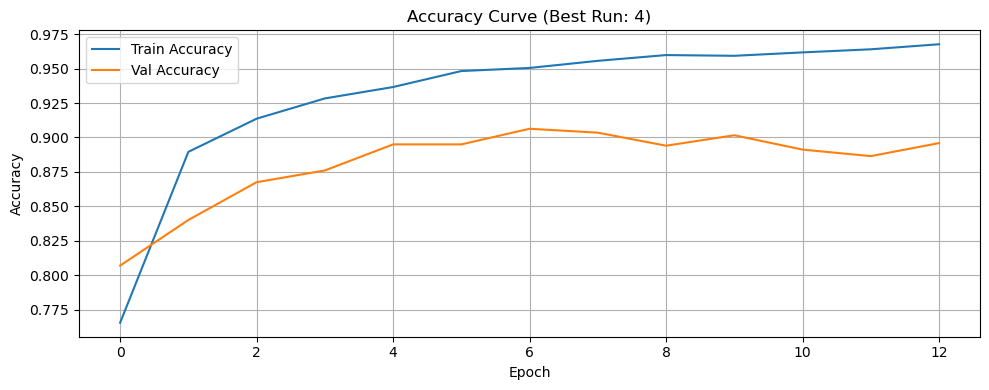

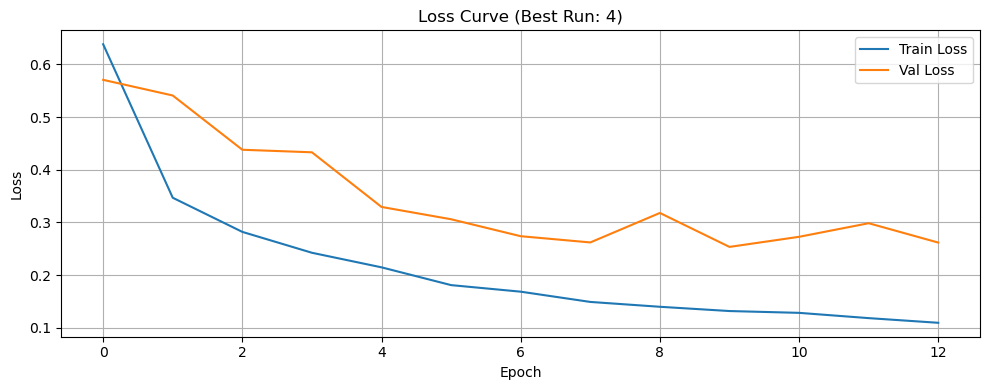


== Confusion Matrix of Best Run (Run 4) ==



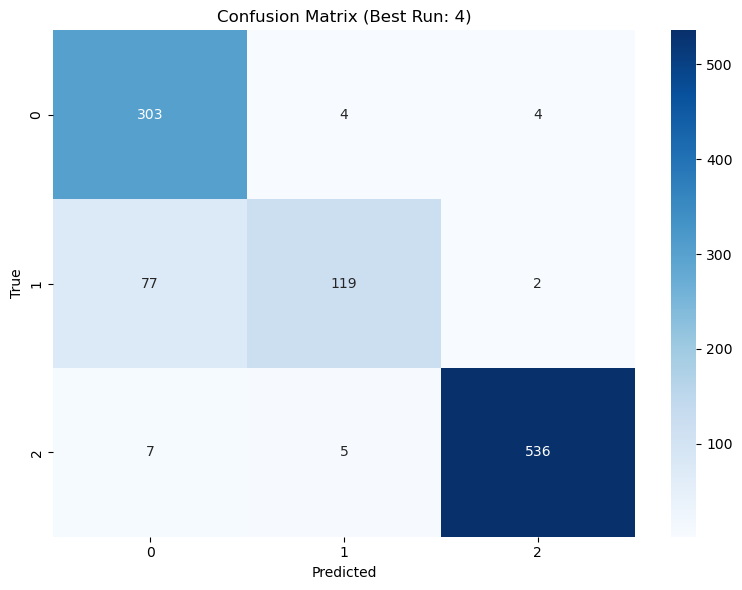

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.928098  0.903477    0.892857    0.835821    0.981752
1     0.903500  0.862523    0.858877    0.745205    0.983486
2     0.907285  0.865726    0.867868    0.745763    0.983547
3     0.906339  0.860581    0.868195    0.730061    0.983486
4     0.910123  0.874664    0.866873    0.775401    0.981718
Mean  0.911069  0.873394    0.870934    0.766450    0.982798
Std   0.008774  0.015797    0.011484    0.037672    0.000868

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.970674,0.890255,0.100626,0.295992
1,0.974648,0.880795,0.086601,0.354834
2,0.973574,0.889309,0.092412,0.281498
3,0.967666,0.895932,0.109363,0.261695
4,0.975078,0.877957,0.085753,0.332498
Mean,0.972328,0.886850,0.094951,0.305303
Std,0.002792,0.006571,0.008952,0.033905


In [29]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8']
test_users = ['user2']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [30]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.829542  0.919614  0.870934   311.000000  0.044480  0.034631   
1             0.847521  0.707071  0.766450   198.000000  0.047401  0.092094   
2             0.985695  0.979927  0.982798   548.000000  0.003215  0.001825   
accuracy      0.911069  0.911069  0.911069     0.911069  0.009809  0.009809   
macro avg     0.887586  0.868871  0.873394  1057.000000  0.013199  0.021307   
weighted avg  0.913867  0.911069  0.909357  1057.000000  0.009386  0.009809   

                                  
              f1-score   support  
0             0.012839  0.000000  
1             0.042118  0.000000  
2             0.000971  0.000000  
accuracy      0.009809  0.009809  
macro avg     0.017662  0.000000  
weighted avg  0.010963  0.000000

## User 3


================ Run 1 ================

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 1 - Accuracy: 0.8828, Macro F1: 0.7770, F1 Class 0: 0.5492, F1 Class 1: 0.8168, F1 Class 2: 0.9650

================ Run 2 ================

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 2 - Accuracy: 0.8689, Macro F1: 0.7609, F1 Class 0: 0.5253, F1 Class 1: 0.8012, F1 Class 2: 0.9561

================ Run 3 ================

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 3 - Accuracy: 0.8716, Macro F1: 0.7078, F1 Class 0: 0.3514, F1 Class 1: 0.8052, F1 Class 2: 0.9667

================ Run 4 ================

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 4 - Accuracy: 0.8785, Macro F1: 0.7568, F1 Class 0: 0.4900, F1 Class 1: 0.8174, F1 Class 2: 0.9628

================ Run 5 ================

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 5 - Accuracy: 0.8631, Macro F1: 0.7487, F1 Class 0: 0.5000, F1 Class 1: 0.7922, F1 Class 2: 0.9538


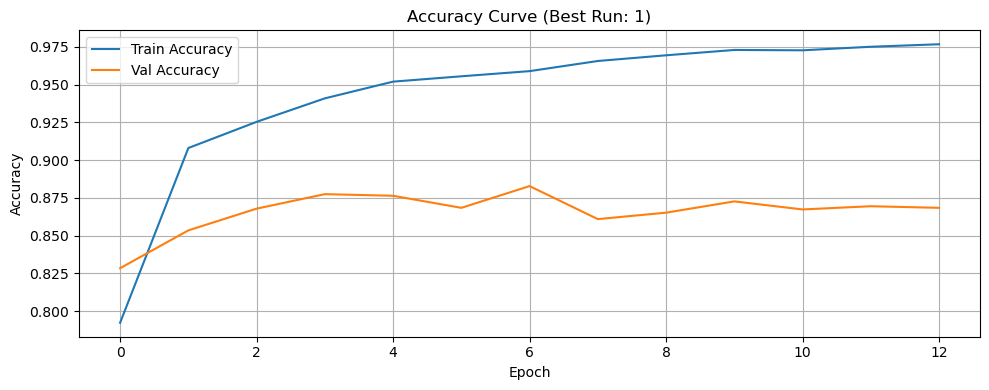

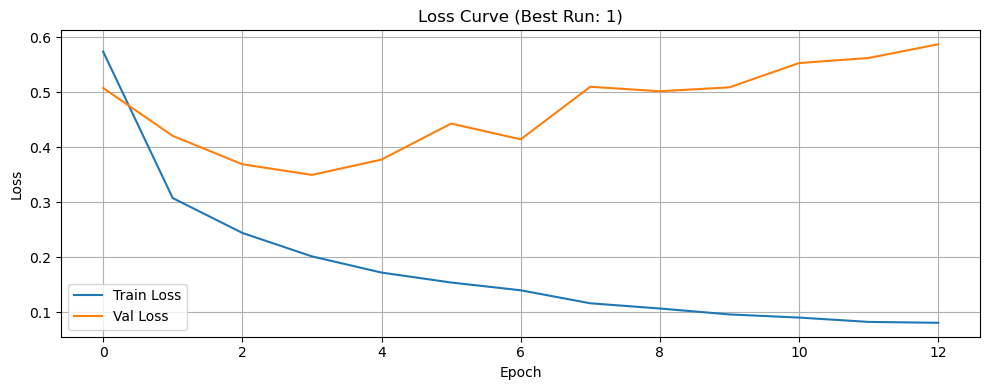


== Confusion Matrix of Best Run (Run 1) ==



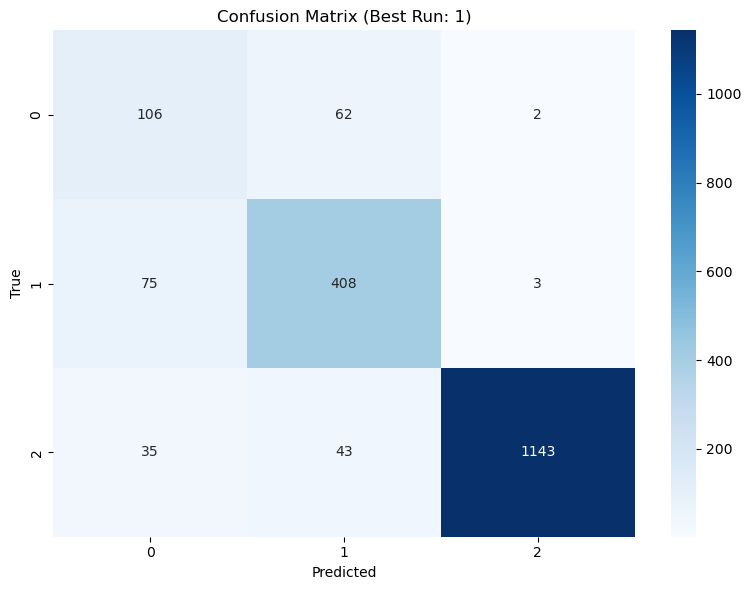

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.882792  0.777001    0.549223    0.816817    0.964964
1     0.868940  0.760851    0.525253    0.801187    0.956114
2     0.871604  0.707753    0.351351    0.805171    0.966737
3     0.878530  0.756753    0.490028    0.817391    0.962838
4     0.863079  0.748693    0.500000    0.792233    0.953846
Mean  0.872989  0.750210    0.483171    0.806560    0.960900
Std   0.006976  0.023146    0.069051    0.009577    0.005040

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.976676,0.868407,0.080603,0.587181
1,0.976793,0.866809,0.076678,0.597552
2,0.975380,0.867342,0.078701,0.623495
3,0.977029,0.858817,0.073161,0.692126
4,0.975733,0.858817,0.077691,0.628241
Mean,0.976322,0.864038,0.077367,0.625719
Std,0.000645,0.004294,0.002471,0.036605


In [31]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user2', 'user4', 'user5', 'user6', 'user7', 'user8']
test_users = ['user3']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [32]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.457470  0.522353  0.483171   170.000000  0.029621  0.129572   
1             0.763512  0.855967  0.806560   486.000000  0.024534  0.027181   
2             0.995622  0.928583  0.960900  1221.000000  0.001343  0.011443   
accuracy      0.872989  0.872989  0.872989     0.872989  0.007799  0.007799   
macro avg     0.738868  0.768968  0.750210  1877.000000  0.017896  0.032789   
weighted avg  0.886783  0.872989  0.877670  1877.000000  0.009002  0.007799   

                                  
              f1-score   support  
0             0.077202  0.000000  
1             0.010707  0.000000  
2             0.005635  0.000000  
accuracy      0.007799  0.007799  
macro avg     0.025878  0.000000  
weighted avg  0.008184  0.000000

## User 4


================ Run 1 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Run 1 - Accuracy: 0.9335, Macro F1: 0.9216, F1 Class 0: 0.8873, F1 Class 1: 0.9161, F1 Class 2: 0.9616

================ Run 2 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Run 2 - Accuracy: 0.9406, Macro F1: 0.9321, F1 Class 0: 0.9073, F1 Class 1: 0.9285, F1 Class 2: 0.9605

================ Run 3 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Run 3 - Accuracy: 0.9330, Macro F1: 0.9209, F1 Class 0: 0.8867, F1 Class 1: 0.9133, F1 Class 2: 0.9625

================ Run 4 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 4 - Accuracy: 0.9316, Macro F1: 0.9192, F1 Class 0: 0.8790, F1 Class 1: 0.9190, F1 Class 2: 0.9596

================ Run 5 ================

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Run 5 - Accuracy: 0.9221, Macro F1: 0.9056, F1 Class 0: 0.8585, F1 Class 1: 0.8959, F1 Class 2: 0.9625


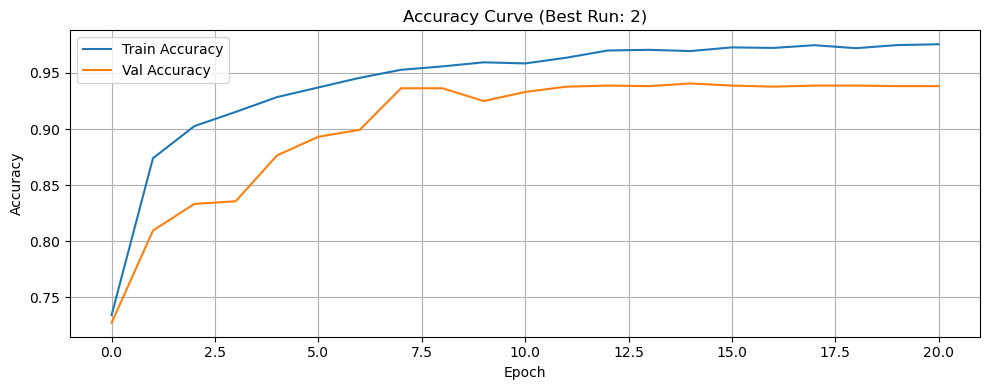

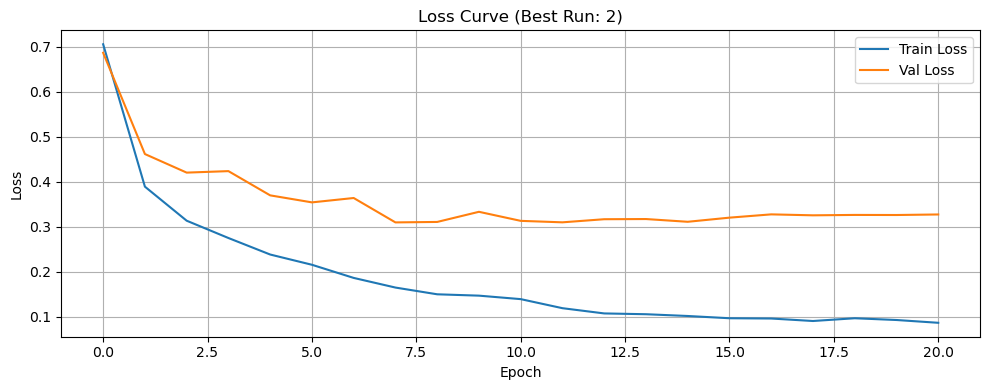


== Confusion Matrix of Best Run (Run 2) ==



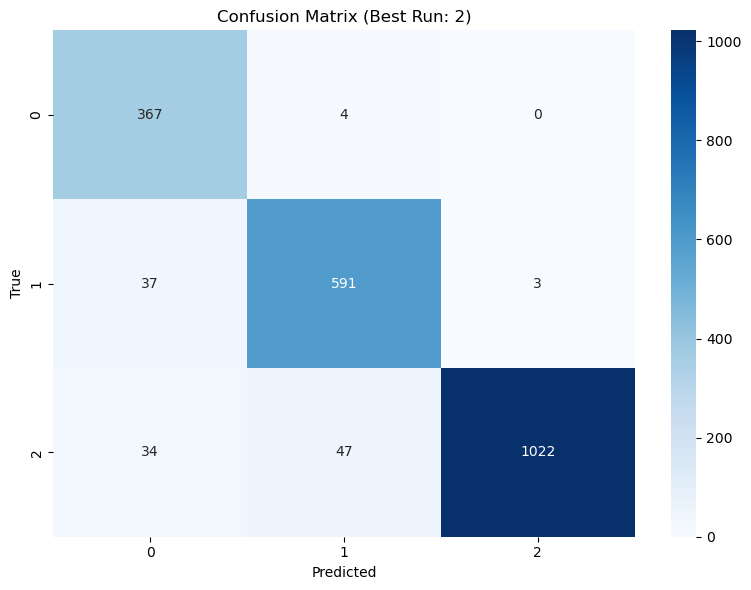

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.933492  0.921638    0.887273    0.916067    0.961575
1     0.940618  0.932112    0.907293    0.928515    0.960526
2     0.933017  0.920860    0.886747    0.913323    0.962512
3     0.931591  0.919211    0.879042    0.919006    0.959586
4     0.922090  0.905634    0.858491    0.895935    0.962477
Mean  0.932162  0.919891    0.883769    0.914569    0.961335
Std   0.005929  0.008451    0.015722    0.010632    0.001136

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.978090,0.933017,0.079324,0.350307
1,0.975548,0.938242,0.086450,0.327109
2,0.973974,0.928266,0.088926,0.333918
3,0.976395,0.930641,0.082863,0.339530
4,0.980753,0.911164,0.067713,0.372443
Mean,0.976952,0.928266,0.081055,0.344662
Std,0.002319,0.009168,0.007421,0.015834


In [33]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user2', 'user3', 'user5', 'user6', 'user7', 'user8']
test_users = ['user4']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [34]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.799972  0.987601  0.883769   371.000000  0.027022  0.004088   
1             0.924004  0.905547  0.914569   631.000000  0.004147  0.022569   
2             0.996305  0.928740  0.961335  1103.000000  0.000807  0.002450   
accuracy      0.932162  0.932162  0.932162     0.932162  0.006629  0.006629   
macro avg     0.906760  0.940629  0.919891  2105.000000  0.008984  0.008068   
weighted avg  0.940029  0.932162  0.933646  2105.000000  0.004771  0.006629   

                                  
              f1-score   support  
0             0.017577  0.000000  
1             0.011887  0.000000  
2             0.001270  0.000000  
accuracy      0.006629  0.006629  
macro avg     0.009448  0.000000  
weighted avg  0.006201  0.000000

## User 5


================ Run 1 ================

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Run 1 - Accuracy: 0.9600, Macro F1: 0.9149, F1 Class 0: 0.8201, F1 Class 1: 0.9417, F1 Class 2: 0.9830

================ Run 2 ================

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Run 2 - Accuracy: 0.9662, Macro F1: 0.9305, F1 Class 0: 0.8550, F1 Class 1: 0.9536, F1 Class 2: 0.9830

================ Run 3 ================

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Run 3 - Accuracy: 0.9591, Macro F1: 0.9037, F1 Class 0: 0.7832, F1 Class 1: 0.9427, F1 Class 2: 0.9851

================ Run 4 ================

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Run 4 - Accuracy: 0.9698, Macro F1: 0.9241, F1 Class 0: 0.8261, F1 Class 1: 0.9553, F1 Class 2: 0.9908

================ Run 5 ================

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Run 5 - Accuracy: 0.9627, Macro F1: 0.9084, F1 Class 0: 0.7917, F1 Class 1: 0.9448, F1 Class 2: 0.9887


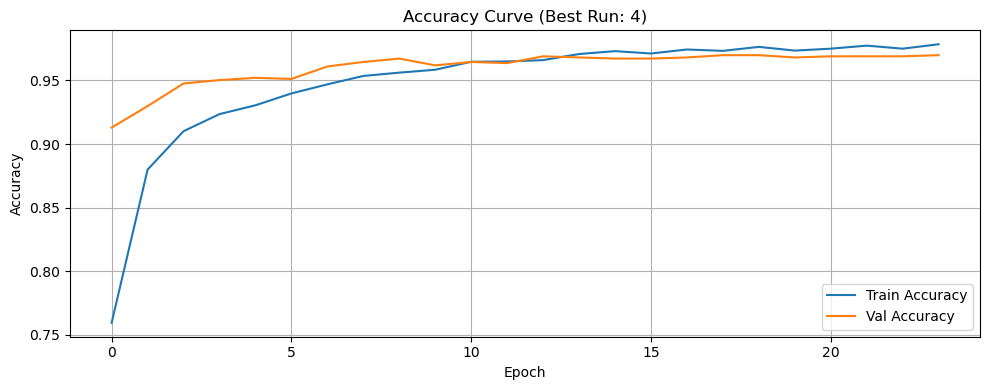

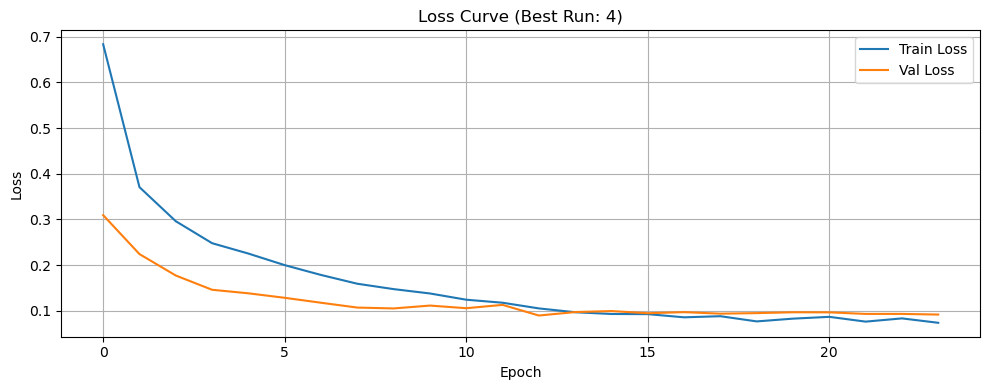


== Confusion Matrix of Best Run (Run 4) ==



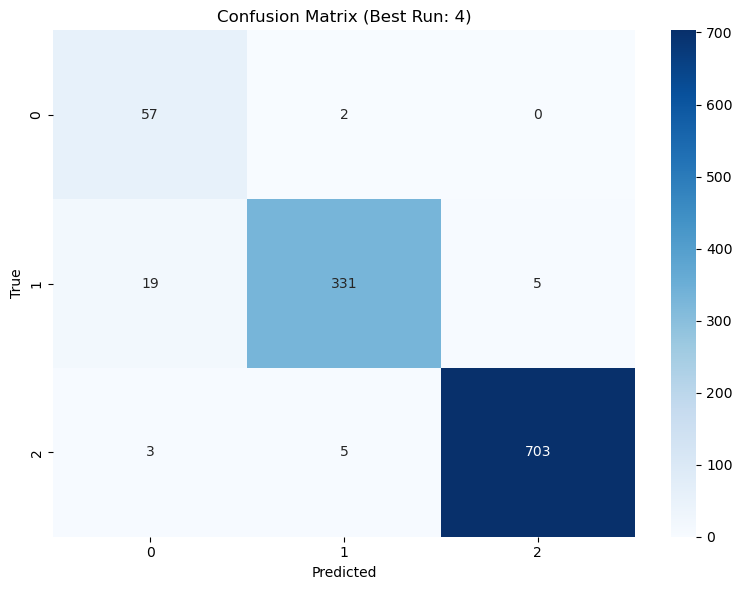

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.960000  0.914926    0.820144    0.941679    0.982955
1     0.966222  0.930501    0.854962    0.953586    0.982955
2     0.959111  0.903669    0.783217    0.942693    0.985096
3     0.969778  0.924064    0.826087    0.955267    0.990839
4     0.962667  0.908384    0.791667    0.944767    0.988717
Mean  0.963556  0.916309    0.815215    0.947599    0.986112
Std   0.003975  0.009860    0.025693    0.005688    0.003165

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.976301,0.950222,0.078844,0.146639
1,0.967969,0.962667,0.108448,0.113748
2,0.969808,0.950222,0.102303,0.143160
3,0.978357,0.969778,0.073521,0.091554
4,0.966779,0.951111,0.107896,0.125185
Mean,0.971843,0.956800,0.094203,0.124057
Std,0.004628,0.008022,0.014964,0.020193


In [35]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user2', 'user4', 'user3', 'user6', 'user7', 'user8']
test_users = ['user5']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [36]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.709810  0.959322  0.815215    59.000000  0.045176  0.009283   
1             0.963569  0.932394  0.947599   355.000000  0.013255  0.014363   
2             0.992875  0.979466  0.986112   711.000000  0.000976  0.007349   
accuracy      0.963556  0.963556  0.963556     0.963556  0.004444  0.004444   
macro avg     0.888751  0.957061  0.916309  1125.000000  0.013921  0.004339   
weighted avg  0.968782  0.963556  0.964996  1125.000000  0.003697  0.004444   

                                  
              f1-score   support  
0             0.028726  0.000000  
1             0.006360  0.000000  
2             0.003539  0.000000  
accuracy      0.004444  0.004444  
macro avg     0.011023  0.000000  
weighted avg  0.004118  0.000000

## User 6


================ Run 1 ================

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 1 - Accuracy: 0.9717, Macro F1: 0.9276, F1 Class 0: 0.8345, F1 Class 1: 0.9570, F1 Class 2: 0.9913

================ Run 2 ================

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 2 - Accuracy: 0.9837, Macro F1: 0.9676, F1 Class 0: 0.9342, F1 Class 1: 0.9767, F1 Class 2: 0.9920

================ Run 3 ================

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Run 3 - Accuracy: 0.9811, Macro F1: 0.9631, F1 Class 0: 0.9272, F1 Class 1: 0.9708, F1 Class 2: 0.9913

================ Run 4 ================

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 4 - Accuracy: 0.9700, Macro F1: 0.9341, F1 Class 0: 0.8592, F1 Class 1: 0.9564, F1 Class 2: 0.9867

================ Run 5 ================

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 5 - Accuracy: 0.9768, Macro F1: 0.9543, F1 Class 0: 0.9067, F1 Class 1: 0.9690, F1 Class 2: 0.9874


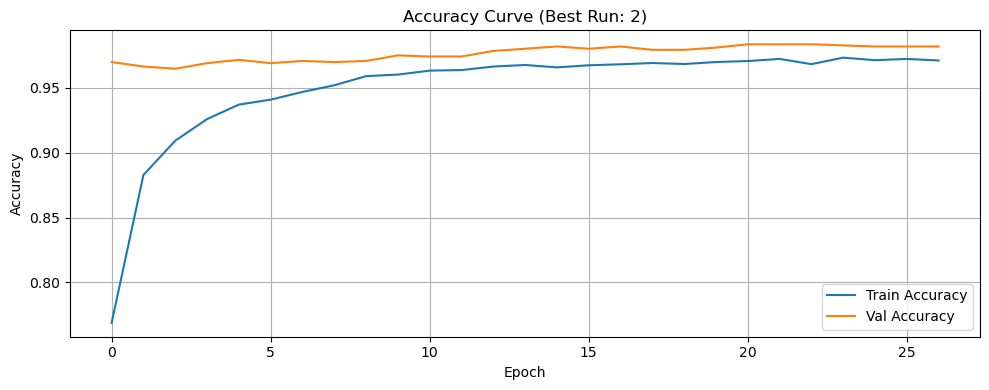

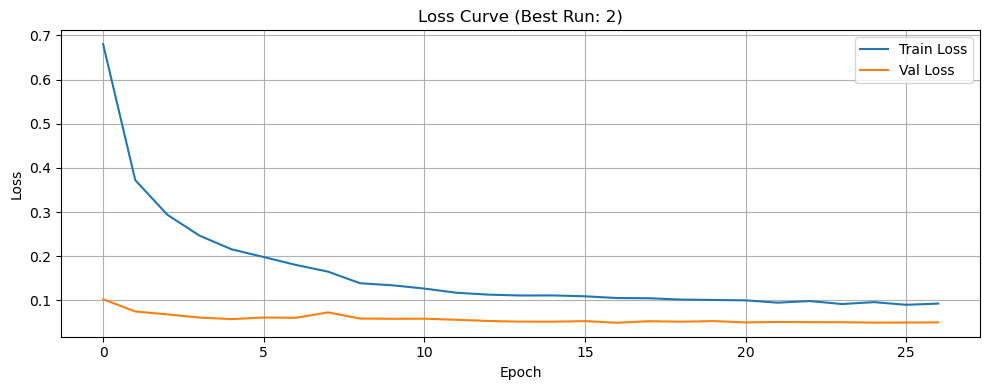


== Confusion Matrix of Best Run (Run 2) ==



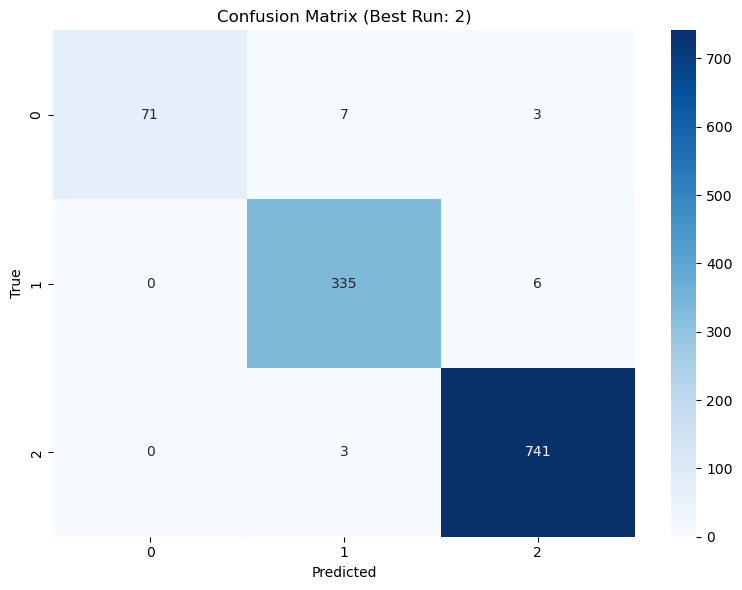

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.971698  0.927619    0.834532    0.957020    0.991304
1     0.983705  0.967618    0.934211    0.976676    0.991968
2     0.981132  0.963101    0.927152    0.970845    0.991304
3     0.969983  0.934078    0.859155    0.956395    0.986684
4     0.976844  0.954341    0.906667    0.968981    0.987375
Mean  0.976672  0.949351    0.892343    0.965984    0.989727
Std   0.005270  0.015832    0.039021    0.007990    0.002226

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.973152,0.971698,0.088756,0.069203
1,0.971196,0.981990,0.092924,0.050428
2,0.974130,0.981132,0.084910,0.060192
3,0.956087,0.969983,0.153428,0.078336
4,0.956630,0.975129,0.149290,0.061335
Mean,0.966239,0.975986,0.113862,0.063899
Std,0.008124,0.004851,0.030749,0.009363


In [37]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user2', 'user4', 'user5', 'user3', 'user7', 'user8']
test_users = ['user6']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [38]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.997101  0.809877  0.892343    81.000000  0.006481  0.071242   
1             0.959225  0.973021  0.965984   341.000000  0.016921  0.009133   
2             0.983058  0.996505  0.989727   744.000000  0.005609  0.001202   
accuracy      0.976672  0.976672  0.976672     0.976672  0.005892  0.005892   
macro avg     0.979795  0.926467  0.949351  1166.000000  0.005334  0.024402   
weighted avg  0.977063  0.976672  0.976018  1166.000000  0.005628  0.005892   

                                  
              f1-score   support  
0             0.043627  0.000000  
1             0.008934  0.000000  
2             0.002489  0.000000  
accuracy      0.005892  0.005892  
macro avg     0.017700  0.000000  
weighted avg  0.006340  0.000000

## User 7 and 8


================ Run 1 ================

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Run 1 - Accuracy: 0.8778, Macro F1: 0.7903, F1 Class 0: 0.6282, F1 Class 1: 0.7955, F1 Class 2: 0.9472

================ Run 2 ================

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Run 2 - Accuracy: 0.8905, Macro F1: 0.7979, F1 Class 0: 0.6184, F1 Class 1: 0.8180, F1 Class 2: 0.9574

================ Run 3 ================

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 3 - Accuracy: 0.8852, Macro F1: 0.7812, F1 Class 0: 0.5789, F1 Class 1: 0.8077, F1 Class 2: 0.9570

================ Run 4 ================

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Run 4 - Accuracy: 0.8831, Macro F1: 0.7936, F1 Class 0: 0.6234, F1 Class 1: 0.8060, F1 Class 2: 0.9513

================ Run 5 ================

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 5 - Accuracy: 0.8842, Macro F1: 0.7734, F1 Class 0: 0.5503, F1 Class 1: 0.8103, F1 Class 2: 0.9597


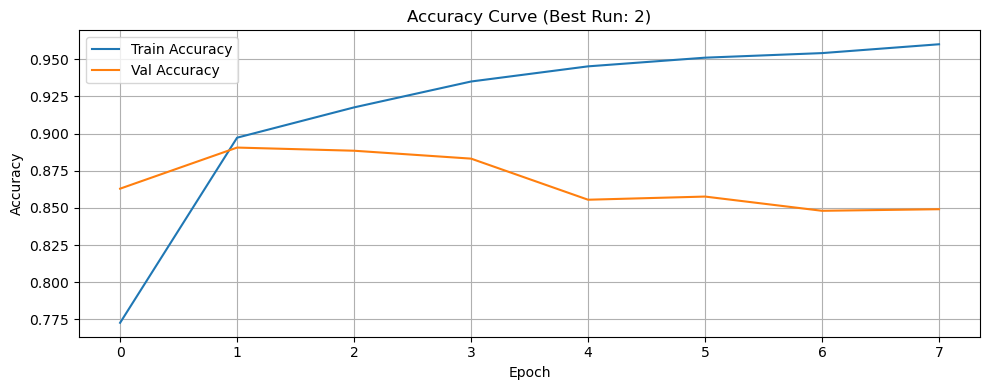

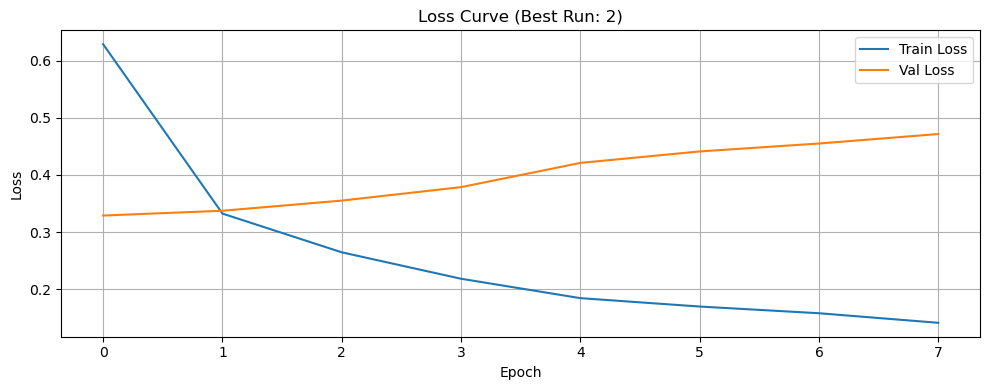


== Confusion Matrix of Best Run (Run 2) ==



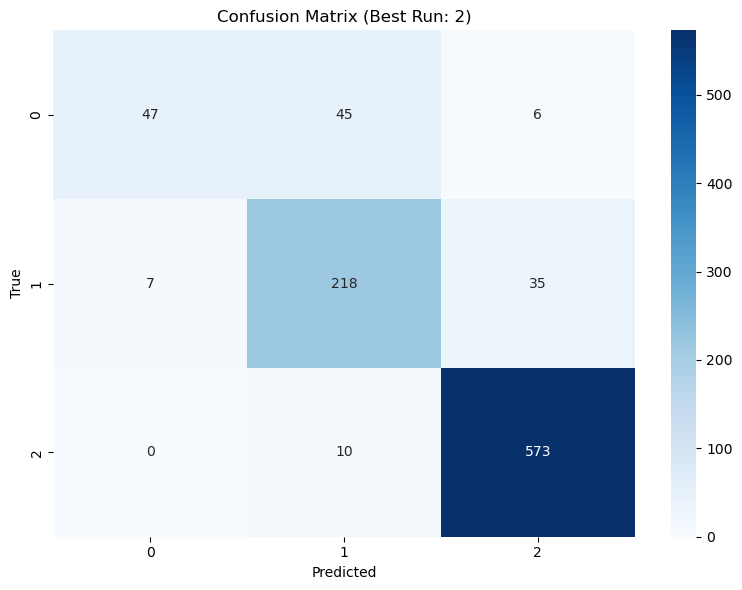

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.877790  0.790298    0.628205    0.795497    0.947192
1     0.890542  0.797942    0.618421    0.818011    0.957393
2     0.885228  0.781221    0.578947    0.807692    0.957025
3     0.883103  0.793563    0.623377    0.805970    0.951342
4     0.884166  0.773438    0.550336    0.810313    0.959664
Mean  0.884166  0.787292    0.599857    0.807497    0.954523
Std   0.004088  0.008838    0.030302    0.007278    0.004578

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.958196,0.831031,0.143291,0.495747
1,0.960000,0.849097,0.141071,0.471602
2,0.959045,0.836344,0.140741,0.444422
3,0.960849,0.819341,0.135359,0.527040
4,0.958727,0.831031,0.144801,0.464877
Mean,0.959363,0.833369,0.141053,0.480738
Std,0.000947,0.009633,0.003212,0.028365


In [40]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# LOOP OVER N RUNS
def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user2', 'user4', 'user5', 'user6', 'user3']
test_users = ['user7', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [41]:
report_summary

Mean                                       Std            \
             precision    recall  f1-score     support precision    recall   
0             0.838215  0.467347  0.599857   98.000000  0.028105  0.033378   
1             0.788556  0.827692  0.807497  260.000000  0.013874  0.015951   
2             0.930925  0.979417  0.954523  583.000000  0.006684  0.009395   
accuracy      0.884166  0.884166  0.884166    0.884166  0.004571  0.004571   
macro avg     0.852565  0.758152  0.787292  941.000000  0.010082  0.008640   
weighted avg  0.881933  0.884166  0.876963  941.000000  0.004771  0.004571   

                                  
              f1-score   support  
0             0.033878  0.000000  
1             0.008137  0.000000  
2             0.005118  0.000000  
accuracy      0.004571  0.004571  
macro avg     0.009882  0.000000  
weighted avg  0.004171  0.000000

# Prototype and Real Product Comparision

## User 1 (Real Products)


================ Run 1 ================

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Run 1 - Accuracy: 0.8496, Macro F1: 0.8574, F1 Class 0: 0.8157, F1 Class 1: 0.8030, F1 Class 2: 0.9535

================ Run 2 ================

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Run 2 - Accuracy: 0.8256, Macro F1: 0.8367, F1 Class 0: 0.7646, F1 Class 1: 0.7865, F1 Class 2: 0.9591

================ Run 3 ================

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Run 3 - Accuracy: 0.8656, Macro F1: 0.8726, F1 Class 0: 0.8330, F1 Class 1: 0.8313, F1 Class 2: 0.9535

================ Run 4 ================

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Run 4 - Accuracy: 0.8112, Macro F1: 0.8234, F1 Class 0: 0.7462, F1 Class 1: 0.7679, F1 Class 2: 0.9560

================ Run 5 ================

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Run 5 - Accuracy: 0.8352, Macro F1: 0.8452, F1 Class 0: 0.7926, F1 Class 1: 0.7838, F1 Class 2: 0.9591


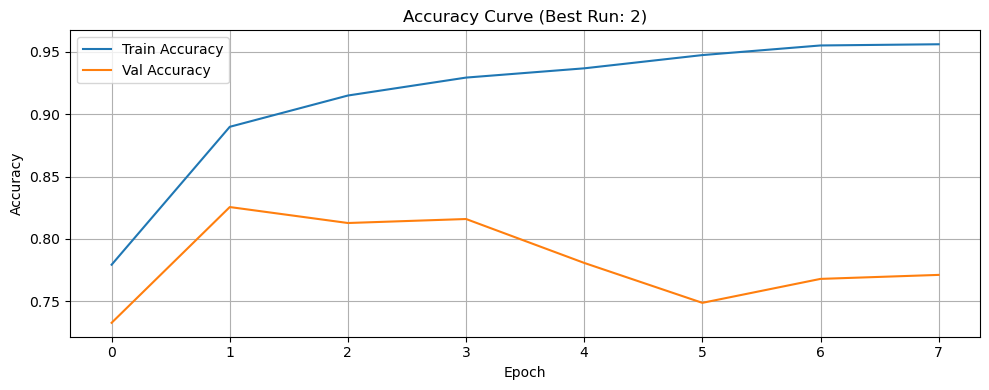

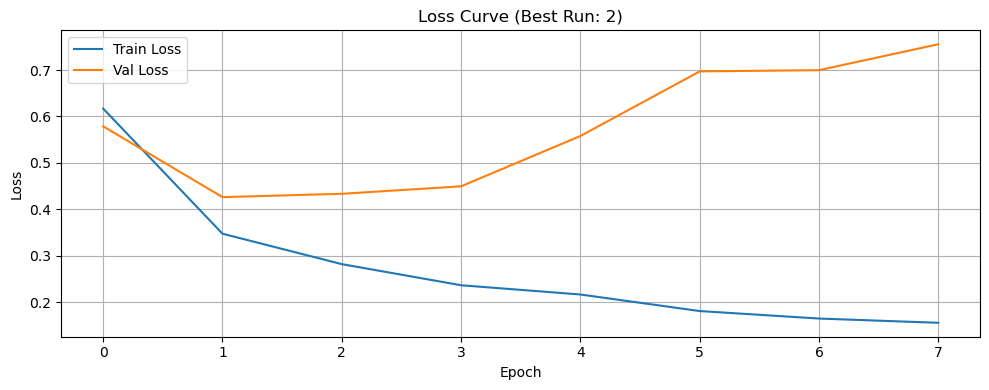


== Confusion Matrix of Best Run (Run 2) ==



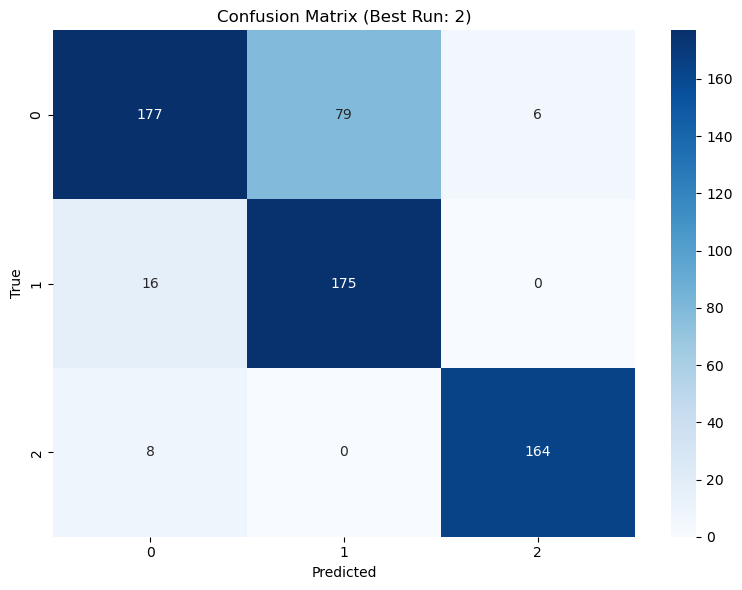

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.849600  0.857402    0.815686    0.803030    0.953488
1     0.825600  0.836720    0.764579    0.786517    0.959064
2     0.865600  0.872594    0.832998    0.831296    0.953488
3     0.811200  0.823358    0.746204    0.767857    0.956012
4     0.835200  0.845173    0.792608    0.783848    0.959064
Mean  0.837440  0.847049    0.790415    0.794510    0.956223
Std   0.018839  0.016919    0.031871    0.021512    0.002496

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.955142,0.732800,0.155491,0.812468
1,0.956106,0.771200,0.155669,0.755459
2,0.955335,0.744000,0.156463,0.801149
3,0.955142,0.729600,0.155493,0.813794
4,0.952441,0.764800,0.160075,0.735385
Mean,0.954833,0.748480,0.156638,0.783651
Std,0.001248,0.016763,0.001756,0.032155


In [151]:
# MODEL FUNCTION
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  # เก็บ classification_report ของแต่ละรอบในรูปแบบ DataFrame
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# LOOP OVER N RUNS
def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        # ดึงค่า train/val จาก epoch สุดท้ายที่ใช้จริง
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        # ======== เก็บ confusion matrix ของ best run
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        # ======== เก็บค่าจาก classification_report
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        # ======== เก็บ summary metric ตามเดิม
        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    
    # Summary
    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    # รวม classification report
    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    # ======= Plot best run learning curve =======
    plot_best_run_learning_curve(histories, val_accuracies)

    # ======== Plot confusion matrix ของ best run
    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_users = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8']
test_users = ['user0101']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)


print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [152]:
report_summary

Mean                                      Std            \
             precision    recall  f1-score    support precision    recall   
0             0.864451  0.730534  0.790415  262.00000  0.017584  0.063444   
1             0.726211  0.880628  0.794510  191.00000  0.050053  0.032988   
2             0.960177  0.952326  0.956223  172.00000  0.006107  0.002600   
accuracy      0.837440  0.837440  0.837440    0.83744  0.021063  0.021063   
macro avg     0.850280  0.854496  0.847049  625.00000  0.014410  0.015868   
weighted avg  0.848549  0.837440  0.837297  625.00000  0.013773  0.021063   

                                  
              f1-score   support  
0             0.035633  0.000000  
1             0.024051  0.000000  
2             0.002790  0.000000  
accuracy      0.021063  0.021063  
macro avg     0.018916  0.000000  
weighted avg  0.021397  0.000000

## User 1 (Prototype Products)


================ Run 1 ================

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 1 - Accuracy: 0.9169, Macro F1: 0.8933, F1 Class 0: 0.8569, F1 Class 1: 0.8452, F1 Class 2: 0.9779

================ Run 2 ================

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 2 - Accuracy: 0.9266, Macro F1: 0.9047, F1 Class 0: 0.8726, F1 Class 1: 0.8590, F1 Class 2: 0.9824

================ Run 3 ================

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 3 - Accuracy: 0.9243, Macro F1: 0.9034, F1 Class 0: 0.8674, F1 Class 1: 0.8636, F1 Class 2: 0.9791

================ Run 4 ================

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 4 - Accuracy: 0.9192, Macro F1: 0.8967, F1 Class 0: 0.8627, F1 Class 1: 0.8501, F1 Class 2: 0.9774

================ Run 5 ================

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 5 - Accuracy: 0.9175, Macro F1: 0.8938, F1 Class 0: 0.8565, F1 Class 1: 0.8458, F1 Class 2: 0.9791


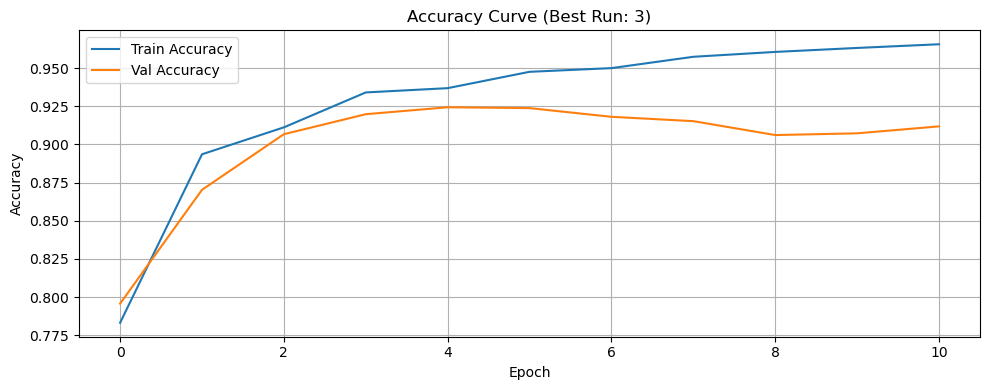

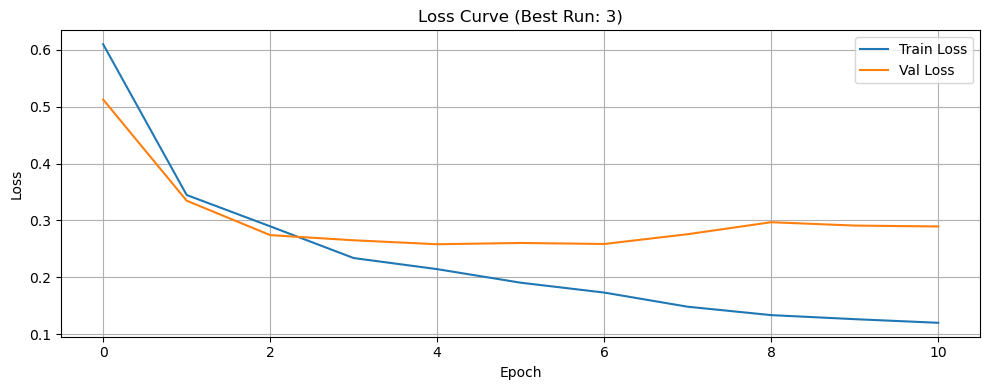


== Confusion Matrix of Best Run (Run 3) ==



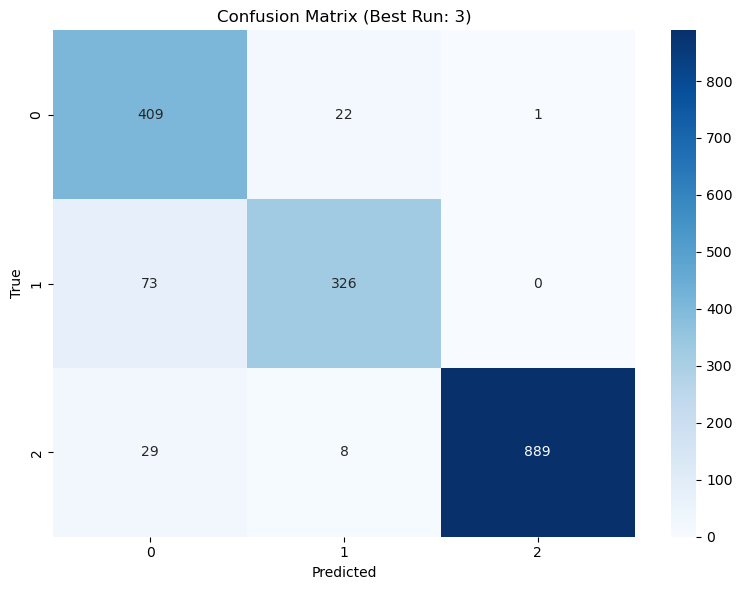

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.916904  0.893322    0.856853    0.845188    0.977925
1     0.926579  0.904672    0.872570    0.859008    0.982437
2     0.924303  0.903365    0.867444    0.863576    0.979075
3     0.919180  0.896711    0.862705    0.850069    0.977361
4     0.917473  0.893785    0.856522    0.845758    0.979075
Mean  0.920888  0.898371    0.863219    0.852720    0.979174
Std   0.003860  0.004773    0.006180    0.007343    0.001762

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.965078,0.910643,0.115241,0.305746
1,0.965464,0.909505,0.121245,0.265828
2,0.965560,0.911781,0.120003,0.289479
3,0.961412,0.907228,0.132365,0.298947
4,0.963728,0.901537,0.125877,0.307882
Mean,0.964249,0.908139,0.122946,0.293576
Std,0.001562,0.003628,0.005801,0.015286


In [156]:
# MODEL FUNCTION
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  # เก็บ classification_report ของแต่ละรอบในรูปแบบ DataFrame
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# LOOP OVER N RUNS
def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        # ดึงค่า train/val จาก epoch สุดท้ายที่ใช้จริง
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        # ======== เก็บ confusion matrix ของ best run
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        # ======== เก็บค่าจาก classification_report
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        # ======== เก็บ summary metric ตามเดิม
        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    
    # Summary
    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    # รวม classification report
    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    # ======= Plot best run learning curve =======
    plot_best_run_learning_curve(histories, val_accuracies)

    # ======== Plot confusion matrix ของ best run
    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_users = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8']
test_users = ['user0102']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)


print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [157]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.792518  0.949074  0.863219   432.000000  0.023099  0.027340   
1             0.915033  0.800000  0.852720   399.000000  0.034316  0.030818   
2             0.999327  0.959827  0.979174   926.000000  0.000614  0.004210   
accuracy      0.920888  0.920888  0.920888     0.920888  0.004316  0.004316   
macro avg     0.902293  0.902967  0.898371  1757.000000  0.006077  0.005121   
weighted avg  0.929336  0.920888  0.921947  1757.000000  0.004053  0.004316   

                                  
              f1-score   support  
0             0.006909  0.000000  
1             0.008210  0.000000  
2             0.001969  0.000000  
accuracy      0.004316  0.004316  
macro avg     0.005337  0.000000  
weighted avg  0.004203  0.000000

## User 2 (Real Products)


================ Run 1 ================

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Run 1 - Accuracy: 0.9715, Macro F1: 0.9704, F1 Class 0: 0.9605, F1 Class 1: 0.9726, F1 Class 2: 0.9783

================ Run 2 ================

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Run 2 - Accuracy: 0.9715, Macro F1: 0.9657, F1 Class 0: 0.9714, F1 Class 1: 0.9474, F1 Class 2: 0.9782

================ Run 3 ================

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Run 3 - Accuracy: 0.9772, Macro F1: 0.9768, F1 Class 0: 0.9694, F1 Class 1: 0.9793, F1 Class 2: 0.9818

================ Run 4 ================

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Run 4 - Accuracy: 0.9753, Macro F1: 0.9769, F1 Class 0: 0.9663, F1 Class 1: 0.9863, F1 Class 2: 0.9782

================ Run 5 ================

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Run 5 - Accuracy: 0.9715, Macro F1: 0.9722, F1 Class 0: 0.9611, F1 Class 1: 0.9793, F1 Class 2: 0.9762


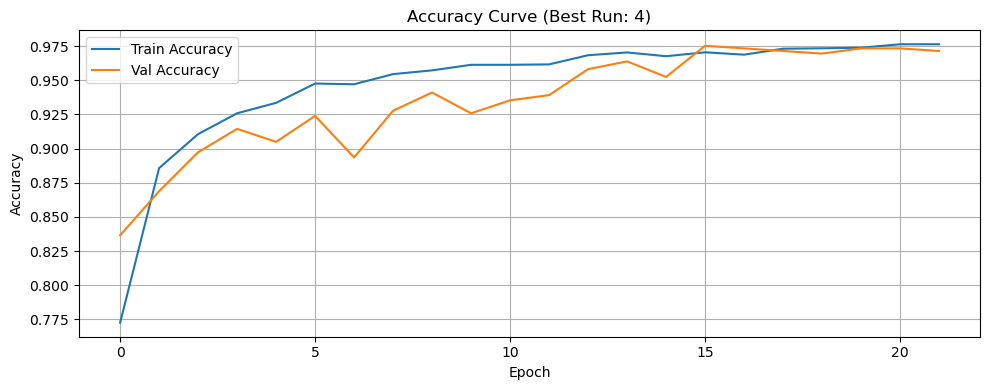

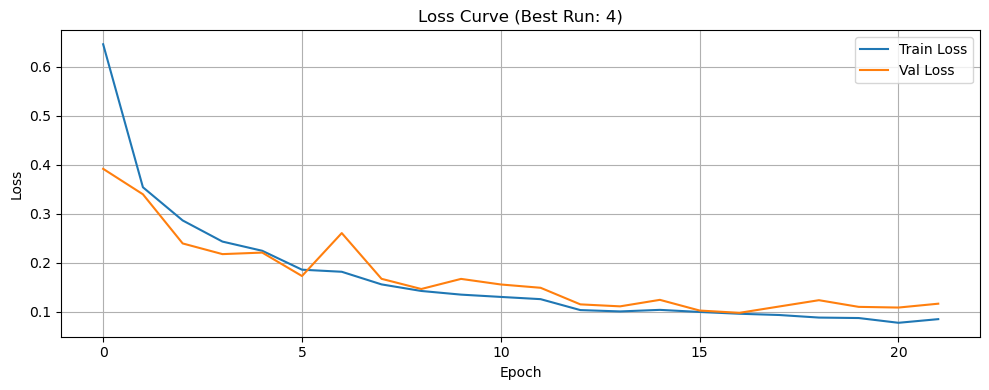


== Confusion Matrix of Best Run (Run 4) ==



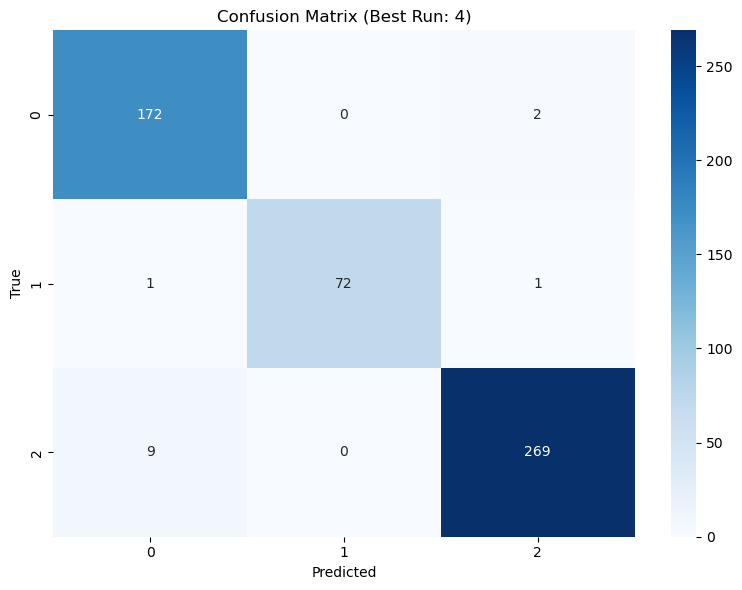

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.971483  0.970439    0.960452    0.972603    0.978261
1     0.971483  0.965660    0.971429    0.947368    0.978182
2     0.977186  0.976807    0.969359    0.979310    0.981752
3     0.975285  0.976925    0.966292    0.986301    0.978182
4     0.971483  0.972218    0.961111    0.979310    0.976234
Mean  0.973384  0.972410    0.965729    0.972979    0.978522
Std   0.002405  0.004224    0.004362    0.013518    0.001787

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.978241,0.967681,0.076215,0.103793
1,0.980580,0.965779,0.066987,0.118651
2,0.979563,0.969582,0.068951,0.122941
3,0.976411,0.971483,0.085374,0.116857
4,0.979563,0.969582,0.073606,0.120290
Mean,0.978871,0.968821,0.074227,0.116507
Std,0.001437,0.001939,0.006463,0.006665


In [161]:
# MODEL FUNCTION
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  # เก็บ classification_report ของแต่ละรอบในรูปแบบ DataFrame
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# LOOP OVER N RUNS
def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        # ดึงค่า train/val จาก epoch สุดท้ายที่ใช้จริง
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        # ======== เก็บ confusion matrix ของ best run
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        # ======== เก็บค่าจาก classification_report
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        # ======== เก็บ summary metric ตามเดิม
        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    
    # Summary
    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    # รวม classification report
    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    # ======= Plot best run learning curve =======
    plot_best_run_learning_curve(histories, val_accuracies)

    # ======== Plot confusion matrix ของ best run
    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_users = ['user1', 'user0201-1', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8']
test_users = ['user0201-2']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)


print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [162]:
report_summary

Mean                                       Std            \
             precision    recall  f1-score     support precision    recall   
0             0.945211  0.987356  0.965729  174.000000  0.013028  0.010281   
1             0.981838  0.964865  0.972979   74.000000  0.033394  0.007402   
2             0.990441  0.966906  0.978522  278.000000  0.004139  0.003940   
accuracy      0.973384  0.973384  0.973384    0.973384  0.002689  0.002689   
macro avg     0.972497  0.973043  0.972410  526.000000  0.007888  0.002985   
weighted avg  0.974269  0.973384  0.973510  526.000000  0.002818  0.002689   

                                  
              f1-score   support  
0             0.004877  0.000000  
1             0.015114  0.000000  
2             0.001998  0.000000  
accuracy      0.002689  0.002689  
macro avg     0.004723  0.000000  
weighted avg  0.002680  0.000000

## User 2 (Prototype Products)


================ Run 1 ================

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Run 1 - Accuracy: 0.7453, Macro F1: 0.5717, F1 Class 0: 0.6679, F1 Class 1: 0.0531, F1 Class 2: 0.9942

================ Run 2 ================

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 2 - Accuracy: 0.7446, Macro F1: 0.5740, F1 Class 0: 0.6654, F1 Class 1: 0.0630, F1 Class 2: 0.9935

================ Run 3 ================

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 3 - Accuracy: 0.7418, Macro F1: 0.5724, F1 Class 0: 0.6630, F1 Class 1: 0.0628, F1 Class 2: 0.9913

================ Run 4 ================

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 4 - Accuracy: 0.7446, Macro F1: 0.5756, F1 Class 0: 0.6642, F1 Class 1: 0.0675, F1 Class 2: 0.9950

================ Run 5 ================

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Run 5 - Accuracy: 0.7467, Macro F1: 0.5766, F1 Class 0: 0.6685, F1 Class 1: 0.0684, F1 Class 2: 0.9928


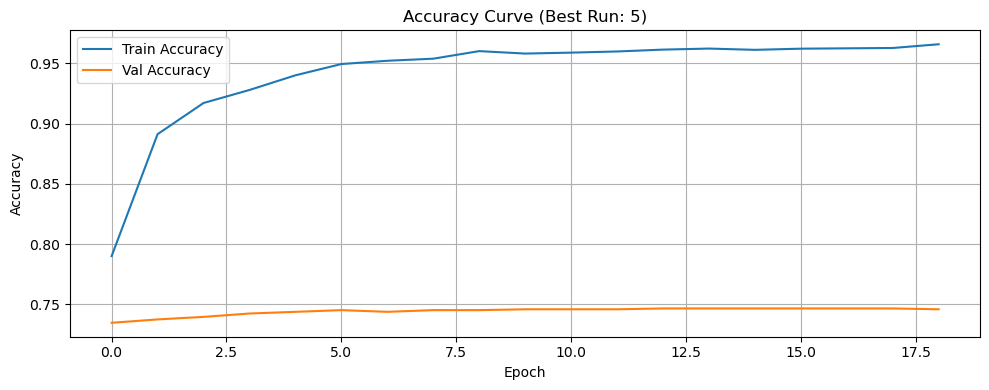

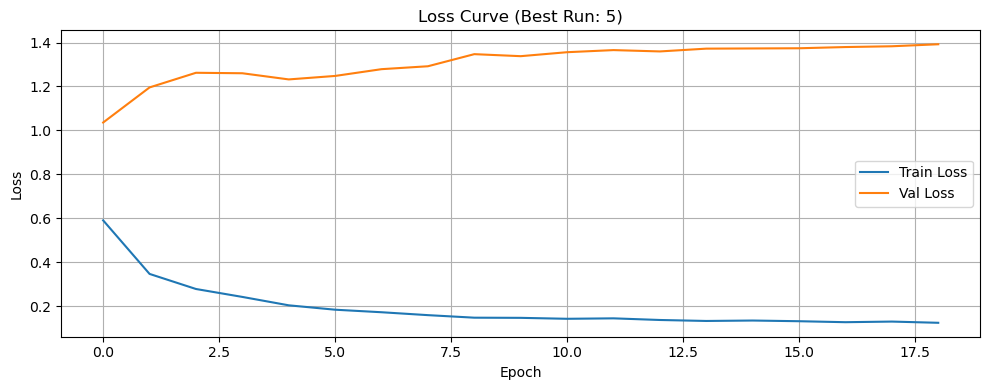


== Confusion Matrix of Best Run (Run 5) ==



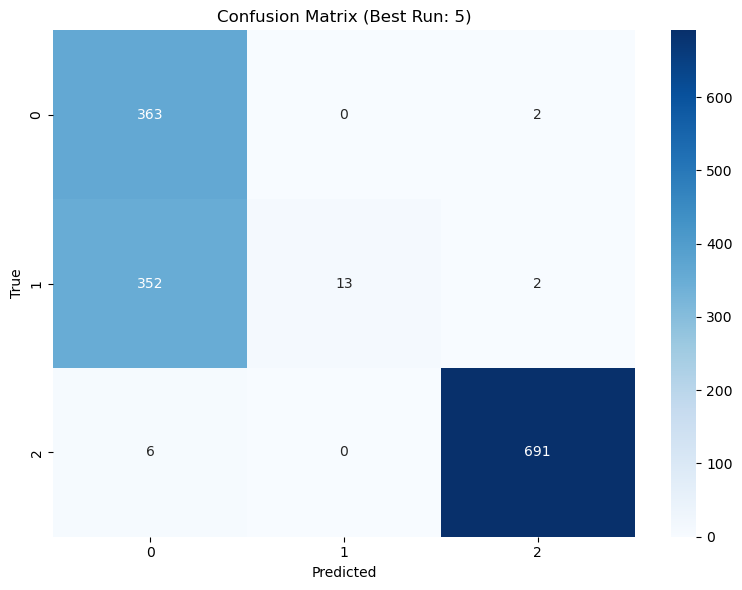

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.745276  0.571724    0.667887    0.053050    0.994236
1     0.744577  0.573985    0.665441    0.062992    0.993521
2     0.741777  0.572387    0.663004    0.062827    0.991329
3     0.744577  0.575567    0.664207    0.067532    0.994960
4     0.746676  0.576582    0.668508    0.068421    0.992816
Mean  0.744577  0.574049    0.665809    0.062965    0.993373
Std   0.001596  0.001838    0.002106    0.005458    0.001247

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.960062,0.744577,0.132534,1.524130
1,0.963052,0.743877,0.127128,1.348296
2,0.959869,0.741777,0.140361,1.366911
3,0.964885,0.743877,0.121168,1.431277
4,0.965753,0.745976,0.123497,1.392384
Mean,0.962724,0.744017,0.128938,1.412599
Std,0.002416,0.001357,0.006880,0.062320


In [159]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# LOOP OVER N RUNS
def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)

        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_users = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8']
test_users = ['user0202']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [160]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.500833  0.992877  0.665809   365.000000  0.001979  0.004977   
1             0.875873  0.032698  0.062965   367.000000  0.123015  0.003337   
2             0.997401  0.989383  0.993373   697.000000  0.001872  0.002975   
accuracy      0.744577  0.744577  0.744577     0.744577  0.001784  0.001784   
macro avg     0.791369  0.671652  0.574049  1429.000000  0.041096  0.001569   
weighted avg  0.839355  0.744577  0.670755  1429.000000  0.031427  0.001784   

                                  
              f1-score   support  
0             0.002355  0.000000  
1             0.006102  0.000000  
2             0.001394  0.000000  
accuracy      0.001784  0.001784  
macro avg     0.002055  0.000000  
weighted avg  0.001679  0.000000